In [15]:
import sys
import argparse
import pandas as pd

from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.preprocessing import divide_fall
from pipeline.feature_extraction import extract_features
from pipeline.processing import fit_and_test_classifiers
from pipeline.evaluation import evaluate_classifiers

from utils.validation import validates_main_experiment_arguments

In [ ]:
SENSORS_AXES = [0, 1, 2, 3, 4, 5]
IGNORED_SUBJECTS = ['SA17', 'SA20', 'SA23', 'SE01', 'SE02', 'SE03', 'SE04', 'SE05', 'SE06', 'SE07', 'SE08', 'SE09', 'SE10', 'SE11', 'SE12', 'SE13', 'SE14', 'SE15']
DURATION = 10000
FREQUENCIES = [ 200]
PRE_TIME = 1500
POST_TIME = 500
CLASSIFICATION = 'binary'
MODELS = ['svm', 'gb', 'knn','dt']
K_FOLD = 5



dataset_folder = "SisFall_dataset/"
output_folder = 'output'
sensors = SENSORS_AXES
ignored_subjects = IGNORED_SUBJECTS
duration = DURATION
frequencies =FREQUENCIES
pre_time = POST_TIME
post_time =POST_TIME
classification = CLASSIFICATION
models = MODELS
k_fold = K_FOLD

# Validates arguments
# errors = validates_main_experiment_arguments(args)
# if len(errors) != 0:
#     print("Problems with script arguments. Please check the following arguments:")
#     [print(e) for e in errors]
#     sys.exit("Invalid arguments. Aborted.")

# Loads SisFall dataset
raw_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)
all_results = []

raw_dataset

Exception ignored in: <function ZipFile.__del__ at 0x105df1800>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/zipfile/__init__.py", line 1940, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/zipfile/__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


,subject,activity,trial,data
0,SA01,D01,R01,acc_x acc_y ...
1,SA01,D01,R01,acc_x acc_y ...
2,SA01,D01,R01,acc_x acc_y ...
3,SA01,D01,R01,acc_x acc_y ...
4,SA01,D01,R01,acc_x acc_y ...
...,...,...,...,...
3395,SA22,F15,R01,acc_x acc_y ...
3396,SA22,F15,R02,acc_x acc_y ...
3397,SA22,F15,R03,acc_x acc_y ...
3398,SA22,F15,R04,acc_x acc_y ...


In [27]:
raw_dataset['data'][0]

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
2000-01-01 00:00:05.000,-0.003906,-0.886719,-0.421875,-0.193878,-0.139550,-0.409061
2000-01-01 00:00:05.005,-0.019531,-0.859375,-0.398438,-0.207726,-0.178964,-0.416518
2000-01-01 00:00:05.010,-0.046875,-0.820312,-0.390625,-0.221575,-0.224771,-0.421844
2000-01-01 00:00:05.015,-0.062500,-0.808594,-0.386719,-0.231162,-0.266316,-0.421844
2000-01-01 00:00:05.020,-0.082031,-0.824219,-0.351562,-0.245011,-0.297209,-0.420779
...,...,...,...,...,...,...
2000-01-01 00:00:14.975,0.027344,-0.953125,0.121094,0.235423,-0.827710,0.110787
2000-01-01 00:00:14.980,0.042969,-0.968750,0.113281,0.260990,-0.837297,0.145941
2000-01-01 00:00:14.985,0.042969,-0.968750,0.105469,0.275903,-0.837297,0.154463
2000-01-01 00:00:14.990,0.035156,-0.968750,0.121094,0.282295,-0.836232,0.148072


In [ ]:
# Reset all_results to ensure it's a list
all_results = []

#  Preprocesses the dataset for each frequency
for frequency in frequencies:
    dataset_list = []
    labels = []

    for i in raw_dataset.index:
        d = raw_dataset['data'][i]
        d = change_activity_duration(d, duration)
        d = change_activity_sampling(d, frequency)

        is_fall = raw_dataset['activity'][i].startswith('F')
      
        
        dataset_list.append(extract_features(d, True))
        labels.append(1 if is_fall else 0)
        

    # Combine all features into a single DataFrame
    dataset = pd.concat(dataset_list, ignore_index=True) if dataset_list else pd.DataFrame()

    # Fits and tests models
    results = fit_and_test_classifiers(dataset, labels, models, k_fold)
    results.insert(0, 'frequency', [frequency] * len(models) * k_fold)
    all_results.append(results)

all_results = pd.concat(all_results, ignore_index=True)
all_results.index = list(range(0, all_results.shape[0]))



Exception ignored in: <function ZipFile.__del__ at 0x105df1800>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/zipfile/__init__.py", line 1940, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/zipfile/__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


    frequency  ksplit                     name abbreviation  \
0         200       1      k-Nearest Neighbour          svm   
1         200       2      k-Nearest Neighbour          svm   
2         200       3      k-Nearest Neighbour          svm   
3         200       4      k-Nearest Neighbour          svm   
4         200       5      k-Nearest Neighbour          svm   
5         200       1  Support Vector Machines           gb   
6         200       2  Support Vector Machines           gb   
7         200       3  Support Vector Machines           gb   
8         200       4  Support Vector Machines           gb   
9         200       5  Support Vector Machines           gb   
10        200       1            Decision Tree          knn   
11        200       2            Decision Tree          knn   
12        200       3            Decision Tree          knn   
13        200       4            Decision Tree          knn   
14        200       5            Decision Tree         

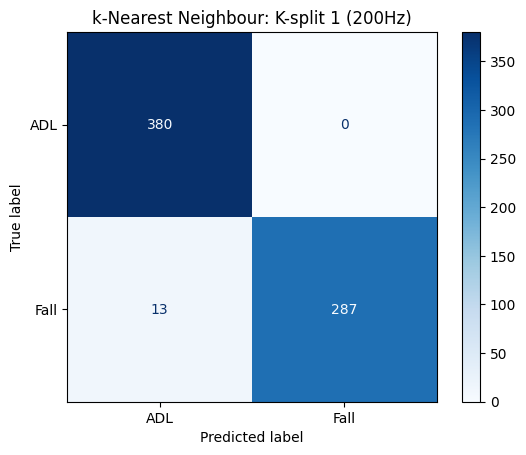

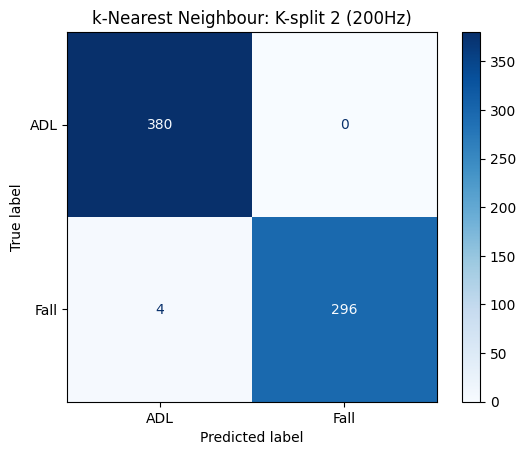

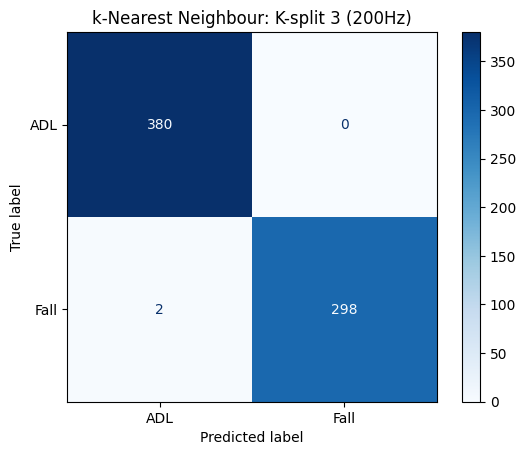

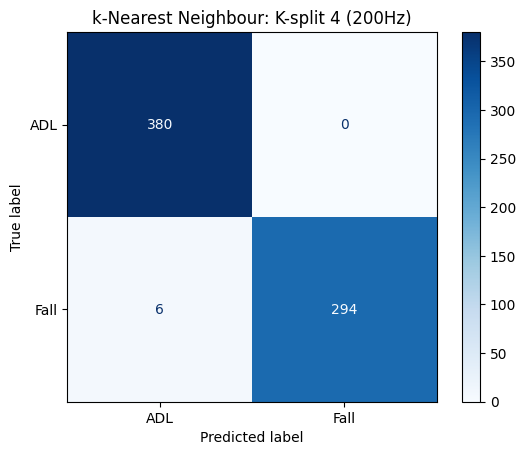

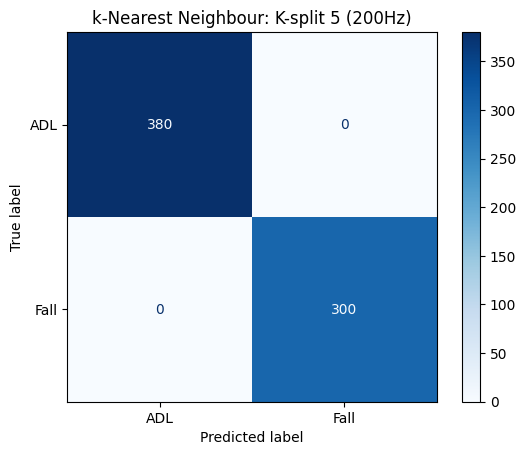

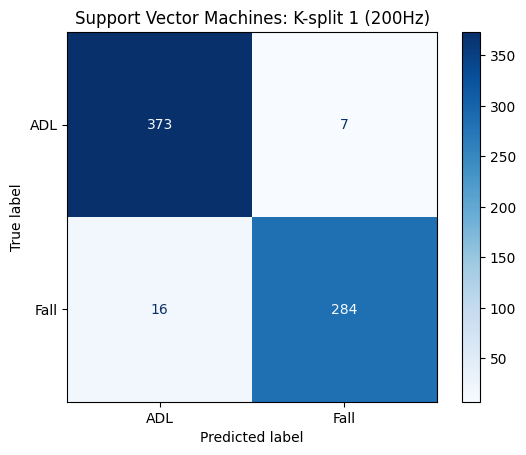

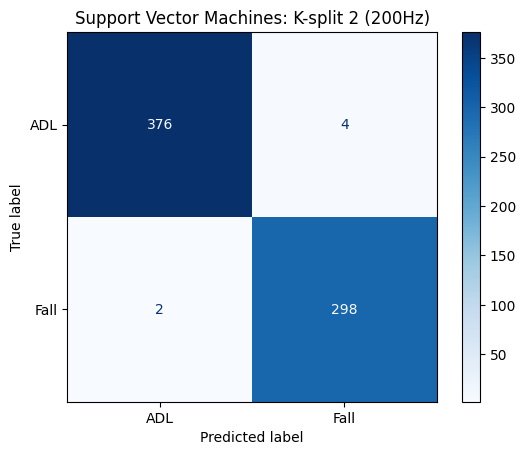

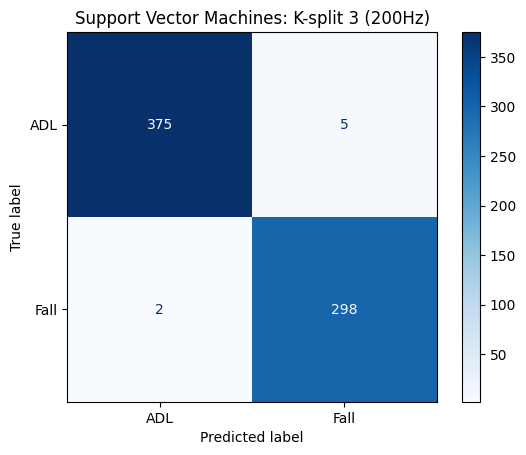

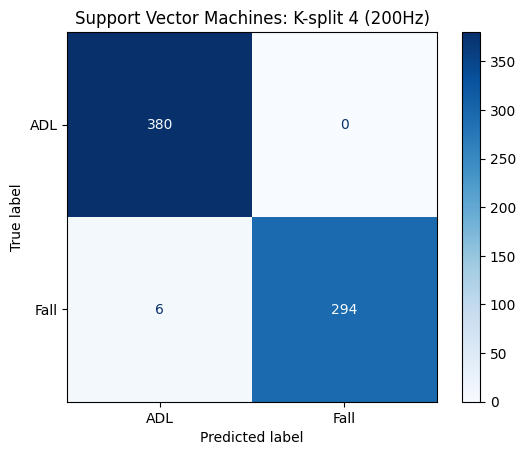

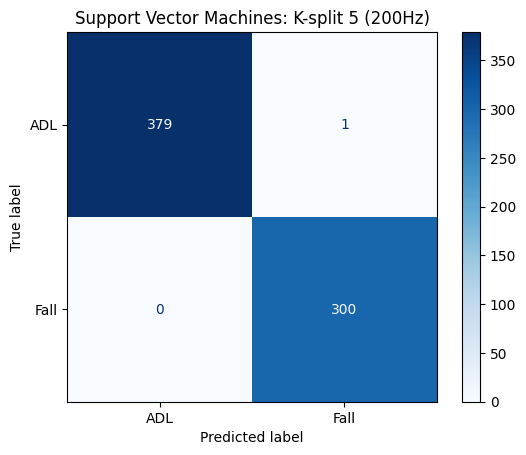

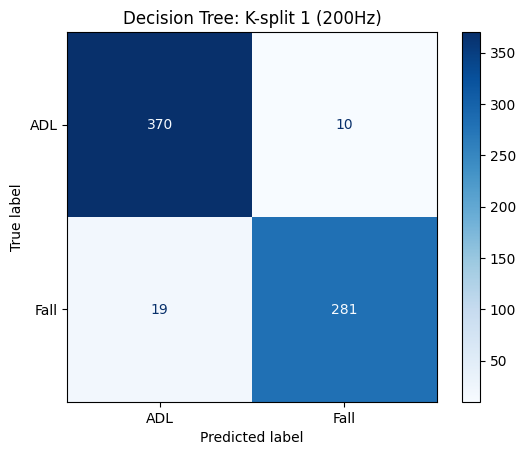

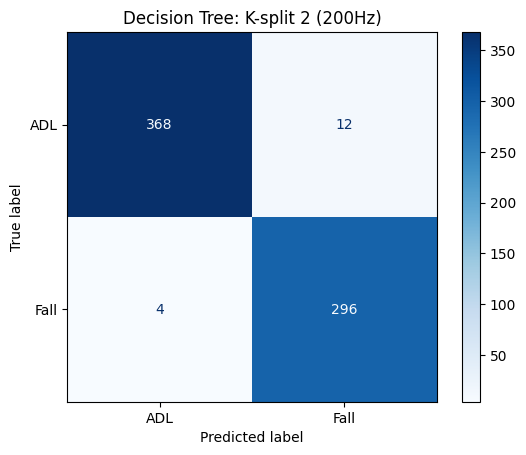

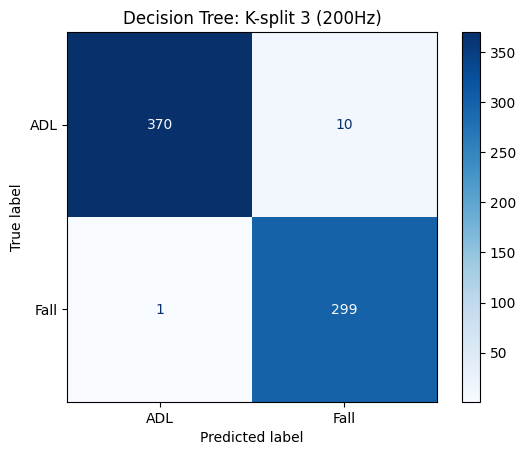

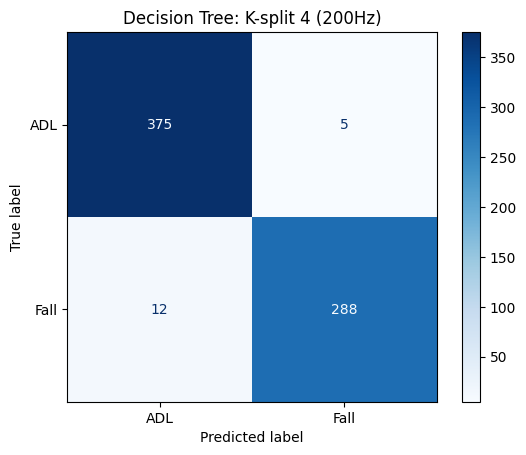

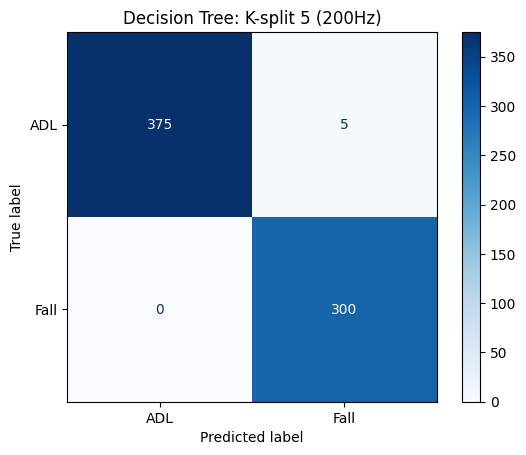

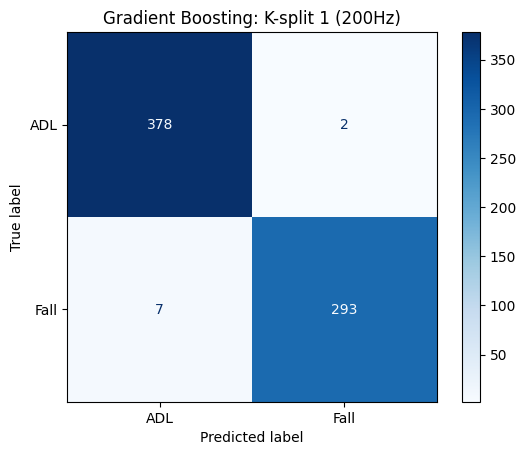

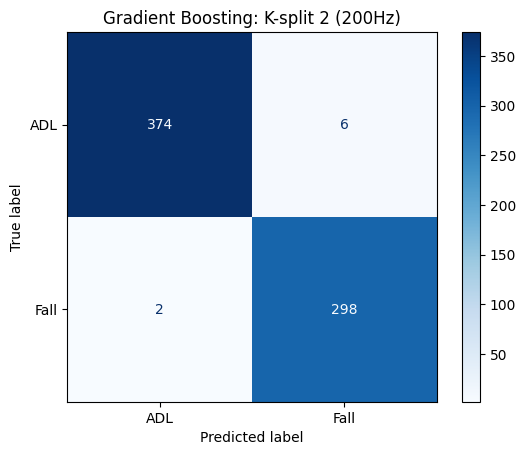

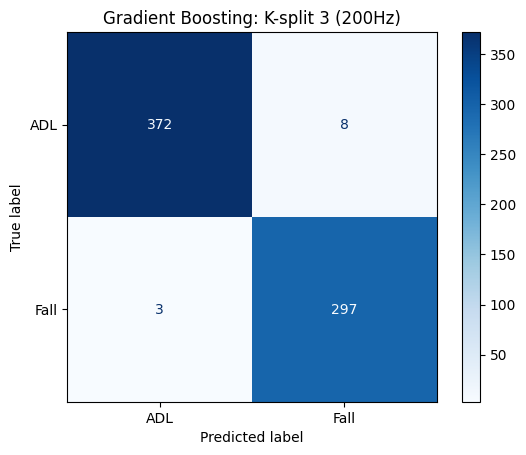

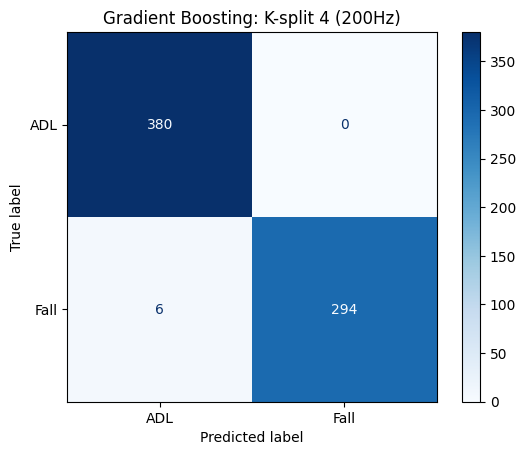

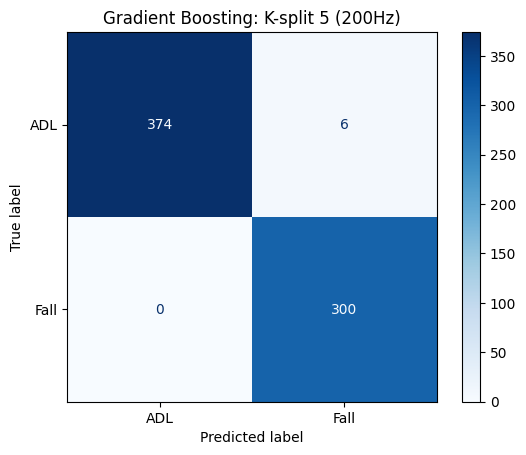

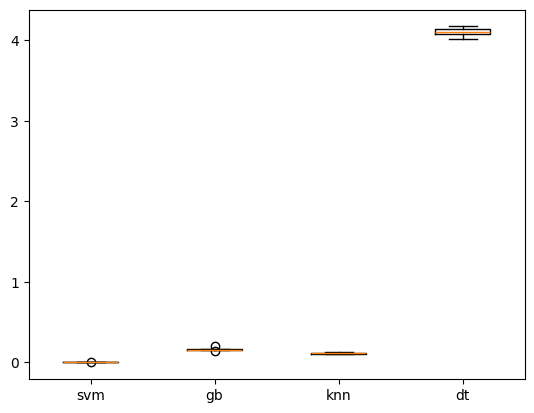

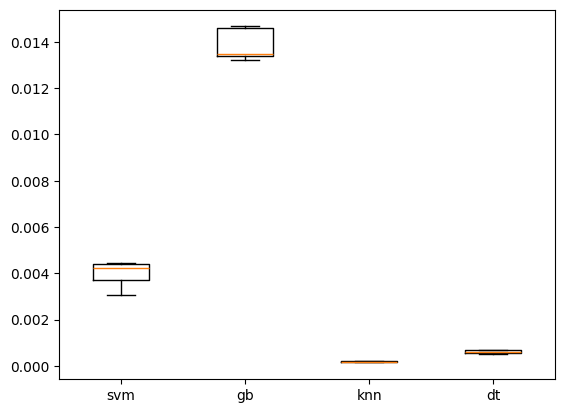

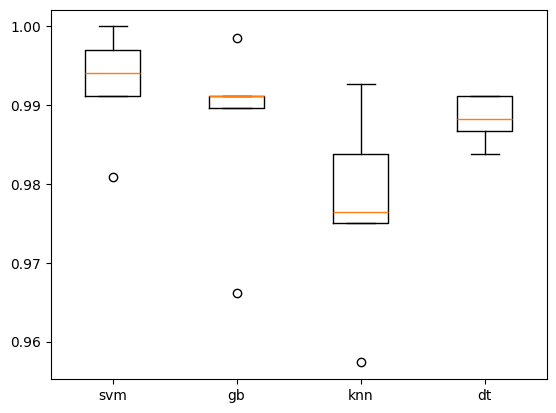

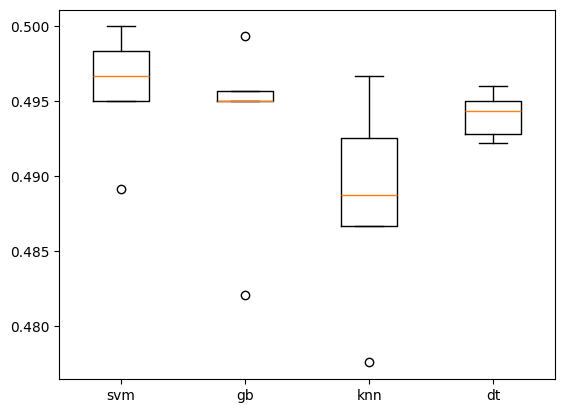

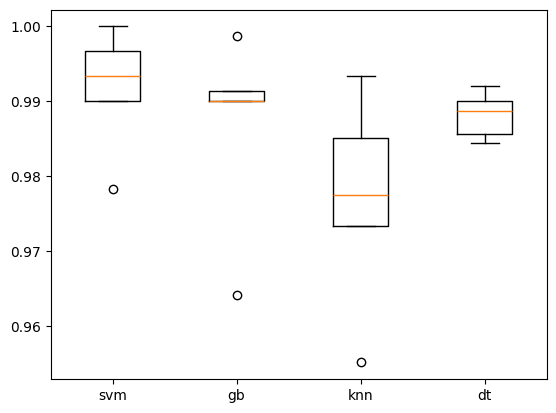

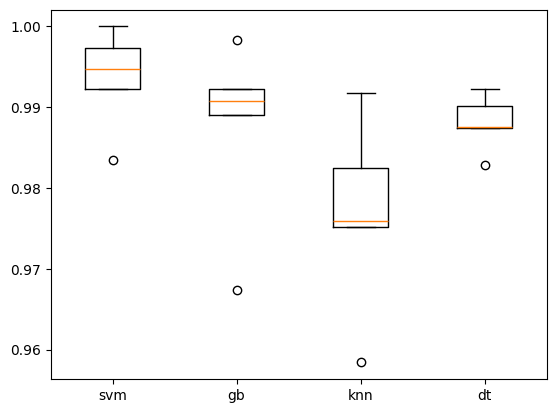

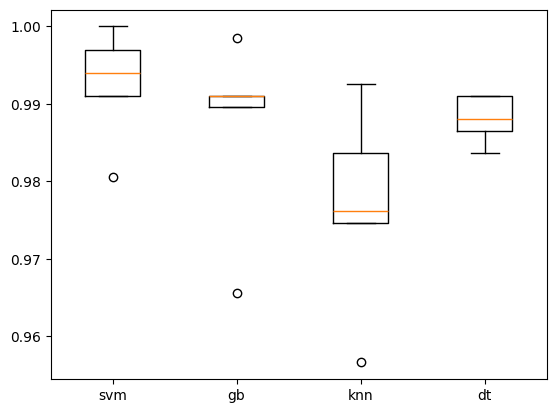

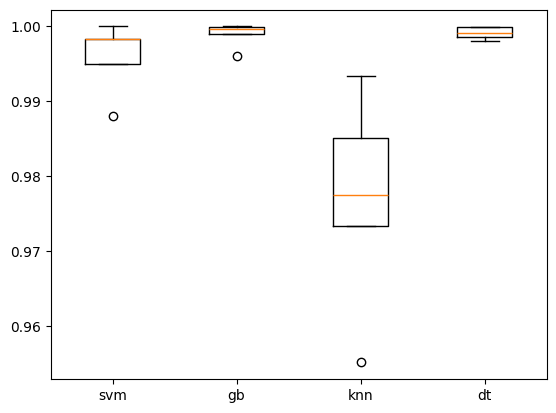

<Figure size 640x480 with 0 Axes>

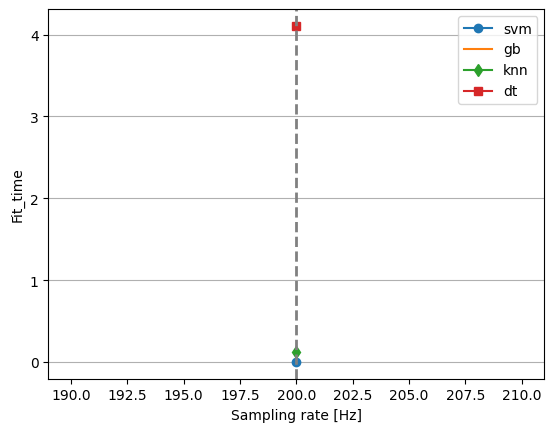

<Figure size 640x480 with 0 Axes>

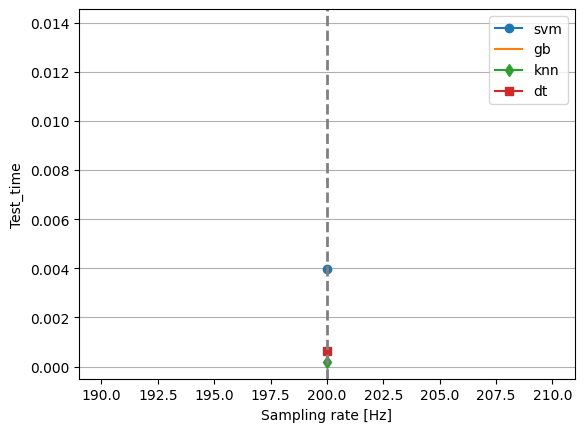

<Figure size 640x480 with 0 Axes>

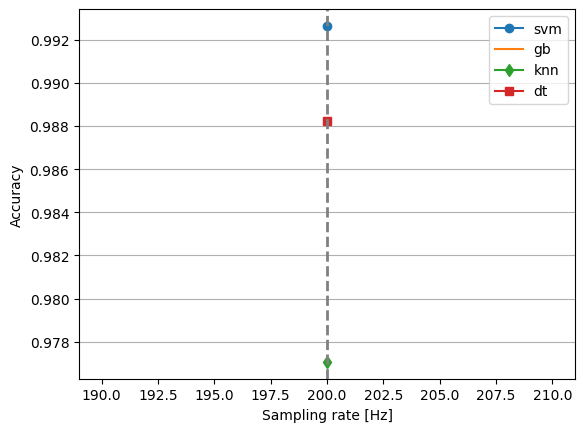

<Figure size 640x480 with 0 Axes>

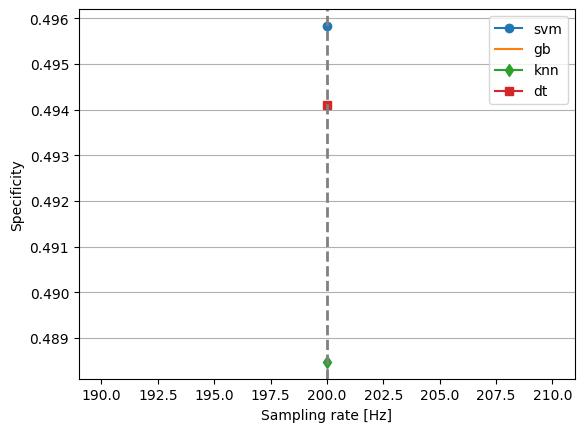

<Figure size 640x480 with 0 Axes>

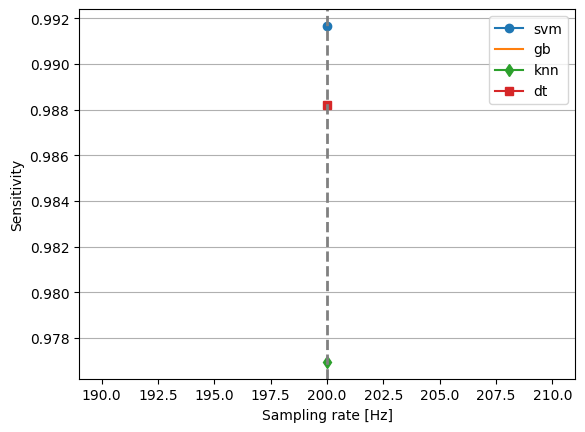

<Figure size 640x480 with 0 Axes>

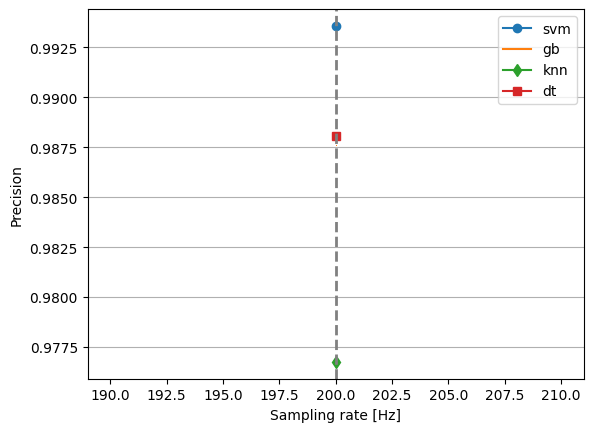

<Figure size 640x480 with 0 Axes>

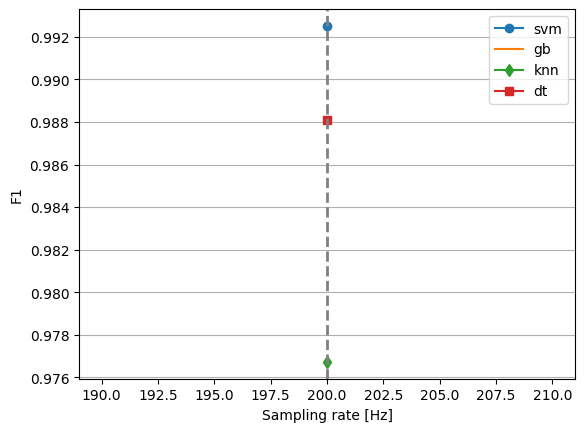

<Figure size 640x480 with 0 Axes>

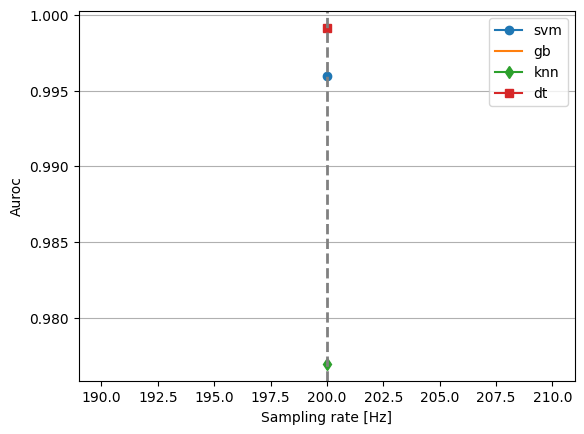

IndexError: At least one sheet must be visible

In [ ]:
class_names = ['ADL', 'Fall'] 
evaluate_classifiers(all_results, output_folder, class_names, frequencies, models, k_fold)